In [119]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.signal as sg
import numba
from tqdm.notebook import tqdm 
tqdm.pandas()
from scipy.signal import decimate

In [5]:
df = pd.read_pickle('tod.pkl')

In [13]:
bolo_time = df['bolotime']*3600.*24
df_tod = df.loc[:, df.columns!='bolotime']
signal = df_tod.values.T
det = list(df_tod.columns)
ndet = len(det)

In [126]:
df_tod = detrend_df(df_tod)
signal = df2signal(df_tod)

  0%|          | 0/361 [00:00<?, ?it/s]

In [127]:
def sample_rate(time):
    return 1/np.mean(np.diff(time))

def eigendecom(cov):
    E,R = np.linalg.eig(cov)
    E[np.isnan(E)] = 0.
    idx = np.argsort(-E)
    return E[idx], R[:, idx]

def create_nmodes(cov,nmodes,R,signal):
    R_n = R[:, :nmodes]
    modes = np.dot(R_n.transpose(), signal)
    return R_n, modes

def cm_subtract(signal,nmodes,det,ret_df=True):
    signal_cm = np.zeros_like(signal)
    cov = np.cov(signal)
    E,R = eigendecom(cov)
    R_n,modes = create_nmodes(cov,nmodes,R,signal)
    for i in range(len(E)):
        signal_cm[i] = signal[i] - np.dot(R_n[i, :], modes)
    
    if ret_df:
        return dataframe(signal_cm,det)
    else:
        return signal_cm

def dataframe(signal,col):
    df = pd.DataFrame(signal.T)
    df.columns = col
    return df

def plot_corr(df):
    plt.figure(figsize=(8,8))
    sns.heatmap(df.corr(),vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            cbar_kws ={'shrink': .6, 'label': 'Correlation'},
            square=True)

In [128]:
def fft(adc):
    series = adc
    # Remove DC
    series = series - np.mean(series)
    # Detrend
    series = sg.detrend(series)
    series_fft = np.fft.rfft(series)
    return series_fft

def get_k(fs=152):
    nfft = len(df)
    time_period = 1/fs
    return np.fft.fftfreq(nfft, time_period)

def get_fft_df(df_time):
    return df_time.progress_apply(fft)


@numba.jit(nopython=True)
def jitsum(x):
    out = 0
    for i in x:
        out += i
    return out

@numba.jit(["float32(complex128[:],complex128[:])"],nopython=True)
def corr(F,G):
    nmrt = jitsum(F*np.conj(G))
    dnrt = np.sqrt(jitsum(np.absolute(F)**2)*jitsum(np.absolute(G)**2))
    return np.real(nmrt/dnrt)

def detrend(adc):
    return adc - np.mean(adc)
def detrend_df(df):
    return df.progress_apply(detrend)
def df2signal(df):
    return df.values.T

In [129]:
def freq_band_modes(fs,begin,end):
    return list(np.where((begin < freq) & (freq < end))[0])  
    
    
    
def get_corr_df(fft_df,freq,lowcut,highcut):
    modes = freq_band_modes(freq,lowcut,highcut)
    fourier_modes = fft_df.iloc[modes]
    K = ndet
    correl = np.zeros((K, K), dtype=float)
    for i, bolo1 in enumerate(tqdm(det,
                                    desc=f"Calculating Correlation Matrix between {lowcut}Hz and {highcut}Hz",
                                    colour='green', unit='detectors')):
        modes1  = fourier_modes[bolo1].values
        for j, bolo2 in enumerate(det):
            modes2 = fourier_modes[bolo2].values
            assert len(modes1) == len(modes2)
            correl[i,j] = corr(modes1,modes2)
            del modes2
        del modes1
    corr_df = pd.DataFrame(correl, index=det, columns=det)
    del (correl,fourier_modes)
    return corr_df

In [130]:
fft_df = get_fft_df(df_tod)

  0%|          | 0/361 [00:00<?, ?it/s]

In [131]:
freq = get_k(sample_rate(bolo_time))

Calculating Correlation Matrix between 0Hz and 154Hz:   0%|          | 0/361 [00:00<?, ?detectors/s]

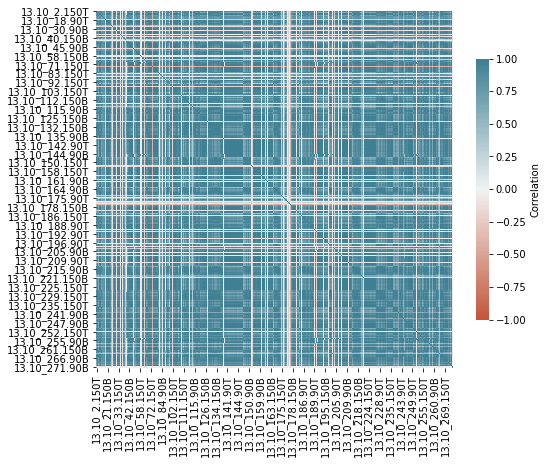

In [138]:
plot_corr(get_corr_df(fft_df,freq,0,154))

In [133]:
cm_df = cm_subtract(signal,10,det)

In [134]:
fft_df_cm = get_fft_df(cm_df)

  0%|          | 0/361 [00:00<?, ?it/s]

Calculating Correlation Matrix between 0Hz and 154Hz:   0%|          | 0/361 [00:00<?, ?detectors/s]

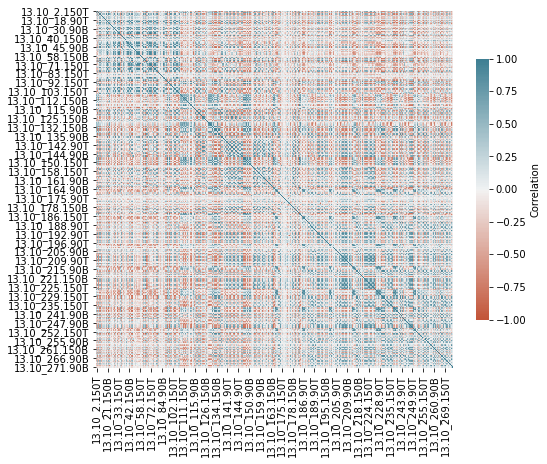

In [139]:
plot_corr(get_corr_df(fft_df_cm,freq,0,154))

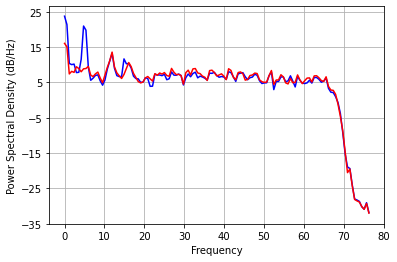

In [136]:
for i in det[:1]:
    null = plt.psd(df_tod[i].values,c='b',Fs=sample_rate(bolo_time))
    null = plt.psd(cm_df[i].values,c='r',Fs=sample_rate(bolo_time))

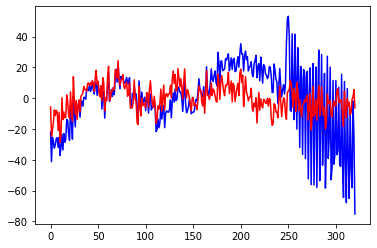

In [137]:
fac=10
for i in det[0:1]:
    null = plt.plot(decimate(df_org_detrend[i].values,fac),c='b')
    null = plt.plot(decimate(cm_df[i].values,fac),c='r')

In [124]:
df_org_detrend = detrend_df(df_tod)
signal = df2signal(df_org_detrend)

  0%|          | 0/361 [00:00<?, ?it/s]